In [1]:
from math import floor
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
import numpy as np
import common # type: ignore
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from IPython.display import display, Markdown, Latex, HTML
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import quantiphy as qq
import warnings
import enum
import os
import importlib
import latex
from latex import dm, pp, ptime, Cites, AC
from latex import Tables, Table, Figure, Figures
from latex import is_latex, set_latex, unset_latex

EPS_TH = 0.5
DATASET = "CTU-13"
database = common.Database()
dataset = common.Dataset()

slots = {}


In [2]:
slots[1] = common.Slot(database, 1 * 60 * 60, EPS_TH, DATASET)
slots[12] = common.Slot(database, 12 * 60 * 60, EPS_TH, DATASET)
slots[24] = common.Slot(database, 24 * 60 * 60, EPS_TH, DATASET)
slots[4 * 24] = common.Slot(database, 4 * 24 * 60 * 60, EPS_TH, DATASET)
slots[7 * 24] = common.Slot(database, 7 * 24 * 60 * 60, EPS_TH, DATASET)

In [7]:
import os
import importlib
import latex
importlib.reload(latex)

from latex import dm, pp, ptime, Cites, AC
from latex import Tables, Table, Figure, Figures
from latex import is_latex, set_latex, unset_latex

In [4]:

dm(f"""

## Time slot analysis

We want to analyse the number of requests in a time window, here called _slot_,
during the evolution of all captures. To achieve this, since that the captures
start in different times, we need to set the starting time of each capture at
the same time. To obtain this, in the Packet-table, we translate all the
timestamps in such a way that the first packet timestamp of each capture is 0 s.


### Distribution of slots

#### Notation

We indicate with $t^s_k$ the timestamp of the $k$-th slot:

$$t^s_k = \\bar{{s}} * k$$

where $s$ is the time slot size.

With $q^s_{{k}}$ we indicate the number of requests belonging to the $k$-th slot,
i.e. performed between
$t^s_{{k-1}}$ and $t^s_{{k}}$,
with ($t^s_{{-1}} = 0$).

Finally, with $N^s = \\lceil t^{{max}} / s \\rceil$ we indicate the total number of slots.

""")



## Time slot analysis

We want to analyse the number of requests in a time window, here called _slot_,
during the evolution of all captures. To achieve this, since that the captures
start in different times, we need to set the starting time of each capture at
the same time. To obtain this, in the Packet-table, we translate all the
timestamps in such a way that the first packet timestamp of each capture is 0 s.


### Distribution of slots

#### Notation

We indicate with $t^s_k$ the timestamp of the $k$-th slot:

$$t^s_k = \bar{s} * k$$

where $s$ is the time slot size.

With $q^s_{k}$ we indicate the number of requests belonging to the $k$-th slot,
i.e. performed between
$t^s_{k-1}$ and $t^s_{k}$,
with ($t^s_{-1} = 0$).

Finally, with $N^s = \lceil t^{max} / s \rceil$ we indicate the total number of slots.



In [5]:
time_translation = database.conn.execute(text(f"""
    SELECT MAX(M.TIME_S) TIME_S,  MAX(M.TIME_S_TRANSLATED) TIME_S_TRANSLATED
    FROM MESSAGE M JOIN PCAP ON M.PCAP_ID = PCAP.ID
    WHERE PCAP.DATASET = '{DATASET}'
""")).all()[0]._mapping

In [6]:
q_per_slot = slot.groupsum("q", use_timestamps=True)

slot_max = q_per_slot.shape[0]
slot_median = int(slot_max / 4)
q_tot = q_per_slot.sum()

q_left50 = q_per_slot.cumsum().iloc[slot_median]
q_right50 = q_per_slot.sum() - q_left50

q_per_slot_cumperc = 100 * q_per_slot.cumsum() / q_tot
q_left50_perc = 100 * q_left50 / q_tot
q_right50_perc = 100 * q_right50 / q_tot

In [7]:
# tab_slot_distribution_cum_perc = Table(
#     slot_distribution_cum_perc_desc.map(lambda x: qq.Quantity(x).render(prec=2)).to_frame().T,
#     Tables.SLOTS,
#     f"Distribution of the slots through time."
# )

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)

# q_per_slot_cumperc.plot(fig=fig)
ax.set_xlabel("$k$")
ax.set_ylabel("$\\sum^k_{j=0}{\\:\\frac{q_j}{q_{tot}}}$", labelpad=16.0, rotation="horizontal", fontsize='x-large')
ax.text(slot_median / 2, 50, f"{q_left50_perc:.2f}%\n{qq.Quantity(q_left50).render(prec=2)}")
ax.text((slot_max + slot_median) / 2, 50, f"{q_right50_perc:.2f}%\n{qq.Quantity(q_right50).render(prec=2)}")

ax.fill_between(np.arange(0, slot_median+1), q_per_slot_cumperc.iloc[0:slot_median+1], alpha=0.4, color="blue")
ax.fill_between(np.arange(slot_median, slot_max), q_per_slot_cumperc.iloc[slot_median:slot_max], alpha=0.2, color="blue")
ax.axvline(slot_median, color="black", lw=1)

slot_ticks = []
for col in range(10):
    v = math.floor(((slot_max) * (0.1 * col)))
    slot_ticks.append(v)
slot_ticks.append(slot_max-1)
ax.set_xticks(slot_ticks)

fig_slot = Figure(fig, ax, Figures.SLOTS,
                  "Percentage of requests made up to slot k.")
fig_slot.ycaption = -.04

plt.close()

In [8]:
q_slot_pcap = slot.df.copy()
q_slot_pcap = q_slot_pcap[["q", "pcap_id", "slotnum"]].groupby(["pcap_id", "slotnum"]).sum()
q_slot_pcap = q_slot_pcap.unstack().T.fillna(0).reset_index(level=0, drop=True)
q_slot_pcap = q_slot_pcap.shift(fill_value=0)
last_row = q_slot_pcap.iloc[-1]
q_slot_pcap = pd.concat([q_slot_pcap, last_row.to_frame().T], ignore_index=True)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)
ax = q_slot_pcap.plot(fig=fig, kind="bar", width=1, stacked=True, logy=False, legend=False, ax=ax)
ax.set_xticks(slot_ticks)
ax.set_xlabel("$k$")
ax.set_ylabel("$q^s_k$", rotation="horizontal", labelpad=16.0, )
ax.axvline(slot_median, color="black", linewidth=0.4)

fig_slot_pcap = Figure(fig, ax, Figures.SLOTS_PCAP,
                       "Each bar indicates the requests number $q^s_k$ of the $k$-th slot.\nThe color indicates the capture which produced the requests.")
fig_slot_pcap.ycaption = -0.2

plt.close()

In [9]:
q_slot_dga = slot.df.copy()
q_slot_dga = q_slot_dga[["q", "dga", "slotnum"]].groupby(["dga", "slotnum"]).sum()
q_slot_dga = q_slot_dga.unstack().T.fillna(0).reset_index(level=0, drop=True)
q_slot_dga = q_slot_dga.shift(fill_value=0)
last_row = q_slot_dga.iloc[-1]
q_slot_dga = pd.concat([q_slot_dga, last_row.to_frame().T], ignore_index=True)


fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)
ax = q_slot_dga.plot(fig=fig, kind="bar", width=1, stacked=True, logy=True , legend=True, ax=ax)
ax.set_xticks(slot_ticks)
ax.set_xlabel("$k$")
ax.set_ylabel("$q^s_k$", rotation="horizontal", labelpad=16.0)
ax.legend(["not-infected", "infected"])
ax.axvline(slot_median, color="black", linewidth=0.4)
plt.close()

fig_slot_dga = Figure(fig, ax, Figures.SLOTS_DGA, "Each bar indicates the requests number $q^s_k$ of the $k$-th slot.\nThe color indicates the capture which produced the requests.")
fig_slot_dga.ycaption = -0.2


In [12]:

dm(f"""
#### Analysis

We set $s =  {ptime(SEC_PER_SLOT / 3600)}$, obtaining
$N^s={slot.df["slotnum"].max()}$.

In Figure {Figures.SLOTS.ref()}, showing the $q_{{s_k}}$ distribution, we can
can observe that:

- The {100 * q_left50 / q_tot:.2f}% ({qq.Quantity(q_left50).render(prec=2)}) of
requests are performed within the first { slot_median / slot_max *
100:.0f}% of the slots.

- The {100 * q_right50 / q_tot:.2f}% ({qq.Quantity(q_right50).render(prec=2)})
of requests are within the last {100 - slot_median / slot_max *
100:.0f} slots.

Furthermore, as we can see in Figure {Figures.SLOTS_DGA.ref()}, the {AC.NIC}
slots are relegated just to the first slot.


""")


fig_slot.show()
fig_slot_pcap.show()
fig_slot_dga.show()


#### Analysis

We set $s =  12 hr$, obtaining
$N^s=142$.

In Figure _[slots]_, showing the $q_{s_k}$ distribution, we can
can observe that:

- The 89.77% (12M) of
requests are performed within the first 25% of the slots.

- The 10.23% (1.37M)
of requests are within the last 75 slots.

Furthermore, as we can see in Figure _[slots-dga]_, the _NIC_
slots are relegated just to the first slot.


#### Conclusion

The data set in unbalanced towards the infected class in many ways:

- The number of requests.

- The capture duration and so the number of slots.

- The number of requests per time.

> Therefore we decide to ignore the last 75% slots, corresponding to 36 of 144 slots.



![](slots.svg "Example")

![](slots-pcap.svg "Example")

![](slots-dga.svg "Example")

### Time slot requests ratio

In [6]:

def slot_boxplot(slots, slot_hours, slot_range, qty_unit, col="q", showfliers=True, onlyfirsts=False):
    if not slot_hours in slots:
        slots[slot_hours] = common.Slot(database, slot_hours * 60 * 60, EPS_TH, DATASET, onlyfirsts=onlyfirsts)
    slot = slots[slot_hours]

    q_slot = slot.df.copy()
    q_slot = q_slot[(q_slot.slotnum >= slot_range[0]) & (q_slot.slotnum < slot_range[1])]
    q_slot = q_slot[[col, "q", "dga", "slotnum"]]
    q_slot = q_slot.groupby(["dga","slotnum"]).agg({"q": "sum", col: lambda x: x.to_list()})
    q_slot.reset_index(inplace=True)

    q_slot = q_slot.pivot(index="slotnum", columns="dga", values=["q", col])
    
    # display(q_slot)

    # box_per_slot = {}
    # for idx, row in q_slot.iterrows():
    #     if not row["slotnum"] in box_per_slot:
    #         box_per_slot[row["slotnum"]] = [None, None]
    #     if row["dga"] == 0:
    #         box_per_slot[row["slotnum"]][0] = { "q": row["q"], "fp": row["pos_nn1"] }
    #     else:
    #         box_per_slot[row["slotnum"]][1] = { "q": row["q"], "fp": row["pos_nn1"] }
    #     pass

    i = 0
    x = []
    xticks_label = []
    xticks_pos = []
    positions = []
    labels = []
    facecolors = []
    edgecolors = []
    widths = []
    totals = []
    # for slot, (box_nic, box_ic) in box_per_slot.items():
    for slot, row in q_slot.iterrows():
        if row[("q", 0)] and row[("q", 2)]:
            positions.append(i - 0.2)
            positions.append(i + 0.2)
        else:
            positions.append(i)
        if row[("q",0)]:
            x.append(row[(col, 0)])
            totals.append(row[("q", 0)])
            xticks_pos.append(slot)
            xticks_label.append(qq.Quantity(1 + slot, units=qty_unit).render(prec=1))
            facecolors.append((0,0,1,0.2))
            edgecolors.append("blue")
            widths.append(0.4)
            # tots.append(
            pass
        if row[("q",2)]:
            x.append(row[(col, 2)])
            totals.append(row[("q", 2)])
            xticks_pos.append(slot)
            xticks_label.append(qq.Quantity(1 + slot, units=qty_unit).render(prec=1))
            facecolors.append((1,0,0,0.2))
            edgecolors.append("red")
            widths.append(0.4)
            pass
        i += 1
        pass
    
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot()
    boxs = ax.boxplot(x,
                      # tick_labels=labels,
                      manage_ticks=False,
                      notch=False,
                      positions=positions,
                      patch_artist=True,
                      showmeans=True,
                      widths=widths,
                      meanline=False,
                      showfliers=showfliers
                    )
    ax.set_xticks(xticks_pos, xticks_label)
    
    for i, b in enumerate(boxs["boxes"]):
        b.set_facecolor(facecolors[i])
        b.set_edgecolor(edgecolors[i])
        pass

    for i, x in enumerate(x):
        ax.text(positions[i], -20, f"{sum(x)}\n{totals[i]}\n{100 * sum(x)/totals[i]:.2f}%", ha="center")
        # ax.text(positions[i], -5, totals[i], ha="center")
        # ax.text(positions[i], -7, f"{100 * sum(x)/totals[i]:.2f}%", ha="center")

    ax.set_ylim(bottom=-8)
    fig = Figure(fig, ax, Figures.SLOTS_DGA, "ciao")
    
    # ax.set_yscale('log')
    
    plt.close()
    return fig

# fig2 = slot_boxplot(slots, 1, (0,14), "hr")
# fig2.show()

In [ ]:
slots = {}
fig1 = slot_boxplot(slots, 1, (0,7), "hour", col="poswl_nn1",
                    showfliers=False, onlyfirsts=True)

fig1.caption = "Number of alarms for the first 10 hour"
fig1.show()
slots = {}
fig1 = slot_boxplot(slots, 1, (0,7), "hour", col="poswl_nn1",
                    showfliers=False, onlyfirsts=False)

fig1.caption = "Number of alarms for the first 10 hour"
fig1.show()

slots = {}
fig1 = slot_boxplot(slots, 1, (0,7), "hour", col="pos_nn1",
                    showfliers=False, onlyfirsts=True)

fig1.caption = "Number of alarms for the first 10 hour"
fig1.show()
slots = {}
fig1 = slot_boxplot(slots, 1, (0,7), "hour", col="pos_nn1",
                    showfliers=False, onlyfirsts=False)

fig1.caption = "Number of alarms for the first 10 hour"
fig1.show()



# slots = {}
# fig1 = slot_boxplot(slots, 24, (0,7), "day",
#                     showfliers=False, onlyfirsts=True)

# fig1.caption = "We can see that the fliers are diffuclt to handle"
# fig1.show()

# slots = {}
# fig1 = slot_boxplot(slots, 24, (0,7), "day",
#                     showfliers=False, onlyfirsts=False)

# fig1.caption = "We can see that the fliers are diffuclt to handle"
# fig1.show()

# slots = {}
# fig1 = slot_boxplot(slots, 24, (0,7), "day",
#                     showfliers=False, onlyfirsts=True)

# fig1.caption = "We can see that the fliers are diffuclt to handle"
# fig1.show()

# slots = {}
# fig1 = slot_boxplot(slots, 24, (0,7), "day",
#                     showfliers=False, onlyfirsts=False)

# fig1.caption = "We can see that the fliers are diffuclt to handle"
# fig1.show()

![](slots-dga.svg "Example")

TypeError: 'float' object is not iterable

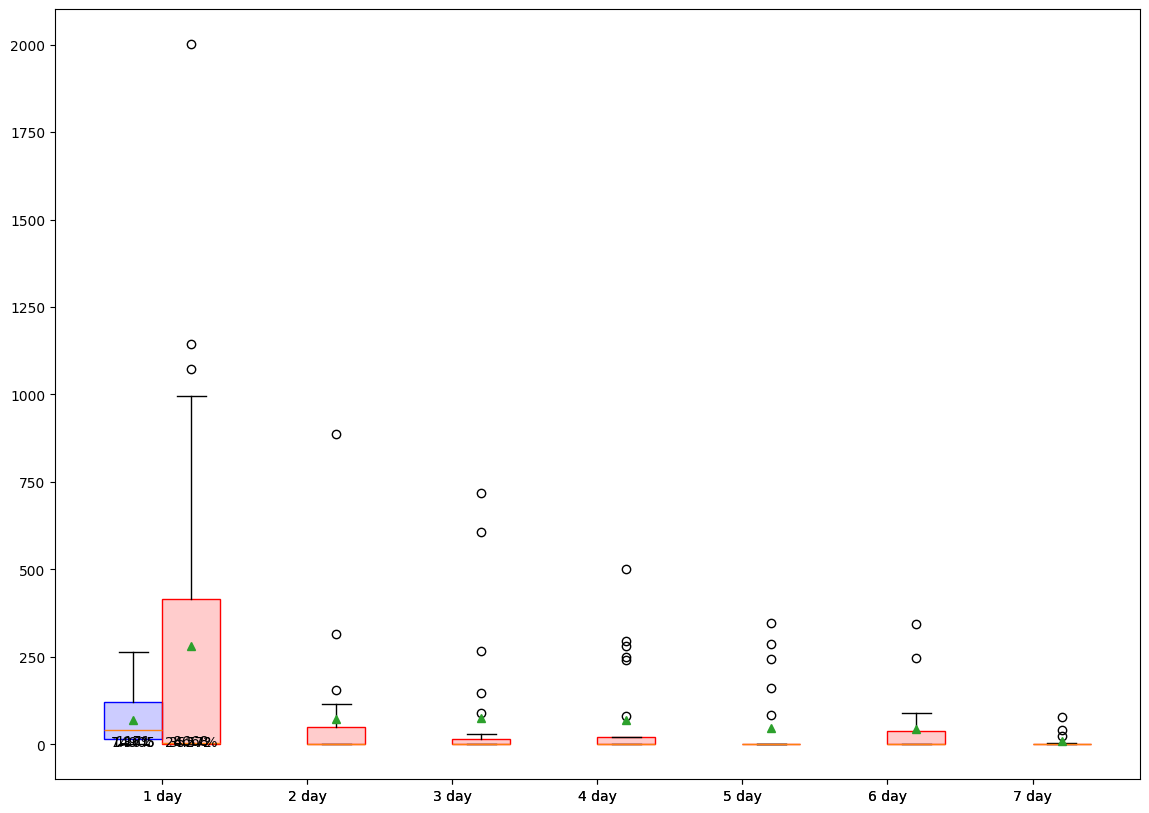

In [229]:

def slot_hist(slots, slot_hours, slot_range, qty_unit, col="q", showfliers=True, onlyfirsts=False):
    if not slot_hours in slots:
        slots[slot_hours] = common.Slot(database, slot_hours * 60 * 60, EPS_TH, DATASET, onlyfirsts=onlyfirsts)
    slot = slots[slot_hours]

    q_slot = slot.df.copy()
    q_slot = q_slot[(q_slot.slotnum >= slot_range[0]) & (q_slot.slotnum < slot_range[1])]
    q_slot = q_slot[["q", "pos_nn1", "dga", "slotnum"]]

    q_slot = q_slot.groupby(["dga","slotnum"]).sum()    
    q_slot = q_slot.unstack(0).fillna(0)

    q_slot[("q",0)] -= q_slot[("pos_nn1",0)]
    q_slot[("q",2)] -= q_slot[("pos_nn1",2)]
    
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot()
    for dga in [0,2]:
        bottom = np.zeros(q_slot.shape[0])
        tmp=q_slot.xs(dga, level=1, axis=1)
        for cc in ["q", "pos_nn1"]:
            rects = ax.bar(
                x=tmp[cc].index.values + (0.2 if dga else -0.2),
                height=tmp[cc].values,
                width=0.3,
                label=cc,
                bottom=bottom
            )
            bottom += tmp[cc].values
            ax.bar_label(rects, labels=[qq.Quantity(v).render(prec=2) for v in rects.datavalues], padding=3, label_type="center")
    fig = Figure(fig, ax, Figures.SLOTS_DGA, "ciao")
    ax.legend()
    plt.close()
    return fig
    
# fig2 = slot_boxplot(slots, 1, (0,14), "hr")
# fig2.show()
fig1 = slot_hist(slots, 24, (0,7), "day", col="pos_nn1",
                    showfliers=True, onlyfirsts=True)
fig1.caption = "We can see that the fliers are diffuclt to handle"
fig1.show()


fig12= slot_boxplot(slots, 24, (0,7), "day", col="pos_nn1",
                    showfliers=True, onlyfirsts=True)
fig2.caption = "We can see that the fliers are diffuclt to handle"
fig2.show()


In [27]:
# slots = {}
fig1 = slot_hist(slots, 24, (0,7), "day", col="pos_nn1",
                    showfliers=True, onlyfirsts=True)

fig1.caption = "We can see that the fliers are diffuclt to handle"
fig1.show()

slots = {}
fig1 = slot_boxplot(slots, 24, (0,7), "day", col="pos_nn1",
                    showfliers=True, onlyfirsts=False)

fig1.caption = "We can see that the fliers are diffuclt to handle"
fig1.show()

![](slots-dga.svg "Example")

![](slots-dga.svg "Example")

In [13]:

pp(f"""
#### Conclusion

The data set in unbalanced towards the infected class in many ways:

- The number of requests.

- The capture duration and so the number of slots.

- The number of requests per time.

> Therefore we decide to ignore the last {100 - slot_median / slot_max *
100:.0f}% slots, corresponding to {slot_median} of {slot_max} slots.
""")


#### Conclusion

The data set in unbalanced towards the infected class in many ways:

- The number of requests.

- The capture duration and so the number of slots.

- The number of requests per time.

> Therefore we decide to ignore the last 75% slots, corresponding to 36 of 144 slots.
